# Limpieza

In [62]:
import math
import nltk
import torch
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import Dataset
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.models import LdaModel
from gensim import corpora , models
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\panda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\panda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
datos = pd.read_csv('dataset/final-train.csv')
datos.head()

,Summary,Text,Score
0,Can really notice when I am not drinking it,I have had hormone problems in the past couple...,5
1,"Okay, just not the best",This is a decent balsamic glaze/reducation.<br...,4
2,"goo source of fiber, not so much a source of c...",the cookie is moist and chewy and has a great ...,3
3,Great GF Staple,I have a 4 yr old and a 2 yr old that can't ea...,5
4,Coffee just doesn't taste right without Sweet ...,We have drunk our coffee for 45 years using th...,5


In [3]:
# Vemos la primera entrada de la columna 'text' y la columna 'summary'
print(datos['Text'][1])

This is a decent balsamic glaze/reducation.<br /><br />It has a faint yeasty taste that I don't care for...not so heavy to preclude using it again, but I have a different brand that I love love love, so this is just a back up.<br /><br />FYI try Blaze balsamic reduction/glaze.  It is superb.


In [4]:
print(datos['Summary'][0])

Can really notice when I am not drinking it


In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426340 entries, 0 to 426339
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Summary  426323 non-null  object
 1   Text     426340 non-null  object
 2   Score    426340 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.8+ MB


In [6]:
def limpiar_datos(dataframe):
    dataframe = dataframe.copy().dropna()
    dataframe['FullText'] = dataframe['Summary'] + ' ' + dataframe['Text']
    dataframe['FullText'] = dataframe['FullText'].str.replace(r'<.*?>', '', regex=True)
    dataframe['FullText'] = dataframe['FullText'].str.replace(r'\d+', '', regex=True)
    dataframe['FullText'] = dataframe['FullText'].str.replace(r'[^\w\s]', ' ', regex=True).str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

    dataframe = dataframe[['FullText','Score']]

    return dataframe

In [7]:
datos_limpio = limpiar_datos(datos)

In [8]:
print(datos_limpio['FullText'][1])

okay best decent balsamic glaze reducation faint yeasty taste care heavy preclude using different brand love love love back fyi try blaze balsamic reduction glaze superb


In [9]:
datos_limpio.head()

,FullText,Score
0,really notice drinking hormone problems past c...,5
1,okay best decent balsamic glaze reducation fai...,4
2,goo source fiber much source chocoate cookie m...,3
3,great gf staple yr old yr old eat gluten aweso...,5
4,coffee taste right without sweet n low drunk c...,5


## Entrenamiento

### Seleccion de datos

In [10]:
map_dict = {1: 0, 2:0, 3:1, 4:1, 5:1}

datos_limpio['Label'] = datos_limpio['Score'].map(map_dict)
datos_limpio.sample(10)

,FullText,Score,Label
27868,excellent bars ordered cranberry almond antiox...,5,1
268855,love flavor mom son love flavor hot chocolate ...,5,1
138238,overpriced least chewy eat chewy lb doberman s...,3,1
345141,great bundle different plants bought time arri...,5,1
326771,candy youth hawaii brought back fond memories ...,5,1
305665,nomnomnomnomnom could live things soooo good u...,5,1
218631,live without suffered chronic candida albicans...,5,1
330285,minced tvp good stuff considering move towards...,5,1
225440,sweet bitter orange delight favorite soda worl...,5,1
117087,treats make easy give glucosamine product labe...,5,1


<Axes: ylabel='Frequency'>

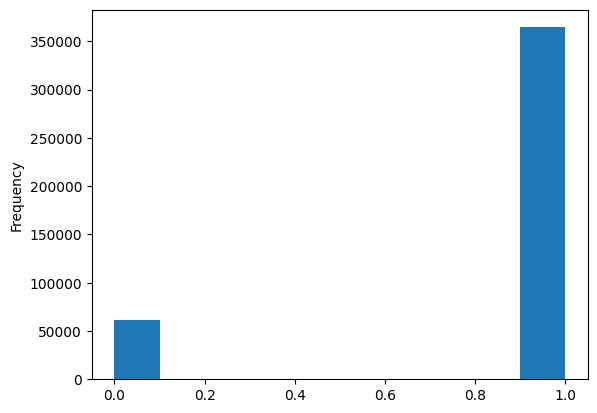

In [11]:
datos_limpio['Label'].plot(kind='hist')

In [12]:
datos_pos = datos_limpio[datos_limpio['Label'] == 1].sample(100000)
datos_neg = datos_limpio[datos_limpio['Label'] == 0]

In [13]:
datos_recortados = pd.concat([datos_neg, datos_pos], ignore_index=True, sort=False)

<Axes: ylabel='Frequency'>

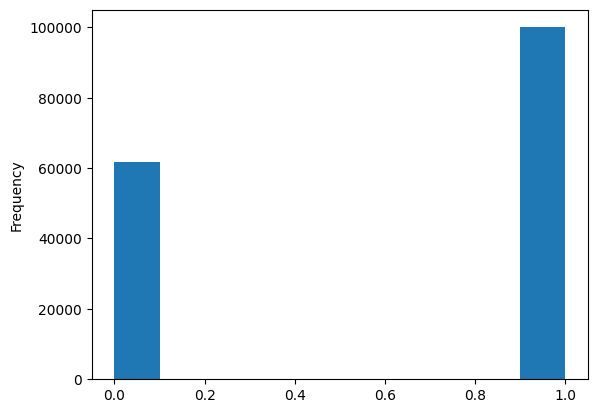

In [14]:
datos_recortados['Label'].plot(kind='hist')

In [15]:
len(datos_recortados['FullText'][0])

281

287.0132219859559


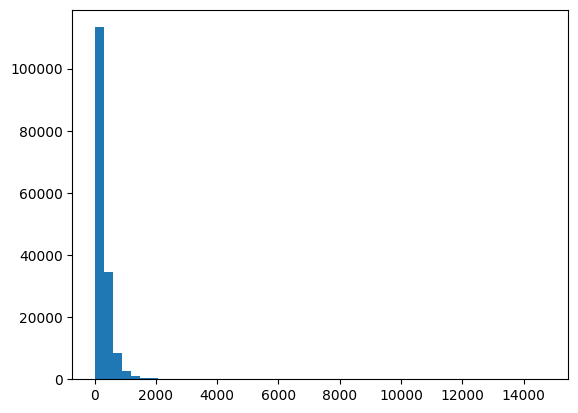

In [16]:
str_lengths = []
for row in datos_recortados['FullText']:
    str_lengths.append(len(row))

print(np.mean(str_lengths))
plt.hist(str_lengths, bins=50)
plt.show()

### Entrenando un modelo de machine learning (NB)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(datos_recortados['FullText'], datos_recortados['Label'], test_size=0.3, random_state=42, stratify=datos_recortados['Label'])

In [27]:
tfidf = TfidfVectorizer(max_features=None)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [21]:
nb_classifier = MultinomialNB()

param_grid = {'alpha': np.arange(0, 1, 0.1),
              'fit_prior': [True, False]}

nb_classifier = GridSearchCV(nb_classifier, param_grid, cv=5, n_jobs=-1)

nb_classifier.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'fit_prior': [True, False]})

In [30]:
best_alpha = nb_classifier.best_params_['alpha']
best_fit_prior = nb_classifier.best_params_['fit_prior']

print(f'Best alpha: {best_alpha}')
print(f'Best fit_prior: {best_fit_prior}')

Best alpha: 0.4
Best fit_prior: False


In [31]:
y_pred = nb_classifier.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83     18533
           1       0.90      0.89      0.89     30000

    accuracy                           0.87     48533
   macro avg       0.86      0.86      0.86     48533
weighted avg       0.87      0.87      0.87     48533



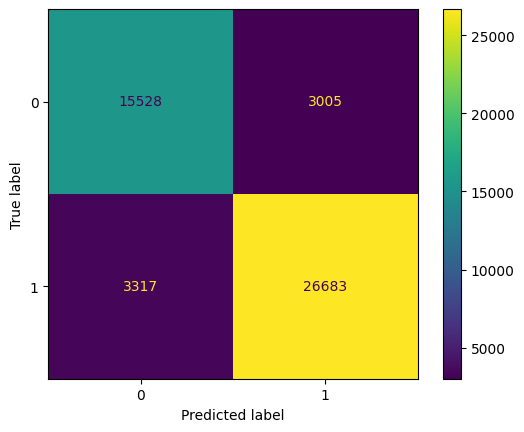

In [32]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()

### Entrenando un modelo tipo BERT

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [54]:
model_name = 'albert/albert-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
# Sample de los datos
sample_pos = datos_recortados[datos_recortados['Label'] == 1].sample(10000)
sample_neg = datos_recortados[datos_recortados['Label'] == 0].sample(10000)

sample = pd.concat([sample_pos, sample_neg], ignore_index=True, sort=False)

In [56]:
sample

,FullText,Score,Label
0,excellent green tea real tea drinker pleasure ...,5,1
1,dogs go crazy chicken arrived dogs smelling bo...,5,1
2,makes wonderful frozen drink enjoy chai tea ho...,5,1
3,outstanding rice blend really pleased ricesele...,5,1
4,delicious reasonably healthy sure really healt...,5,1
...,...,...,...
19995,complete ripoff product complete ripoff gave p...,1,0
19996,pecan pie larabar eating larabar bars years lo...,1,0
19997,fan care coffee first thing noticed opened sme...,2,0
19998,gummy bad taste fifties grew potato buds mom e...,1,0


In [57]:
X_train, X_test, y_train, y_test = train_test_split(sample['FullText'], sample['Label'], test_size=0.2, random_state=42, stratify=sample['Label'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [58]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

In [68]:
# guardamos los encodings
torch.save(train_encodings, 'train_encodings.pt')
torch.save(val_encodings, 'val_encodings.pt')
torch.save(test_encodings, 'test_encodings.pt')

In [59]:
# cantidad de datos en cada conjunto
print(len(train_encodings['input_ids']), len(val_encodings['input_ids']), len(test_encodings['input_ids']))

12800 3200 4000


In [60]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': list(y_train)
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': list(y_val)
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': list(y_test)
})

In [61]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    eval_strategy="epoch",    # Evaluar después de cada época
    learning_rate=1e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.1,
    report_to="none"                # No reportar a Weights & Biases
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset
)

In [62]:
trainer.train()

                                                 
100%|██████████| 200/200 [32:33<00:00,  9.77s/it]

{'eval_loss': 0.6950080394744873, 'eval_runtime': 84.0641, 'eval_samples_per_second': 38.066, 'eval_steps_per_second': 0.595, 'epoch': 1.0}
{'train_runtime': 1953.4952, 'train_samples_per_second': 6.552, 'train_steps_per_second': 0.102, 'train_loss': 0.7204383850097656, 'epoch': 1.0}


TrainOutput(global_step=200, training_loss=0.7204383850097656, metrics={'train_runtime': 1953.4952, 'train_samples_per_second': 6.552, 'train_steps_per_second': 0.102, 'total_flos': 76473925632000.0, 'train_loss': 0.7204383850097656, 'epoch': 1.0})

In [63]:
# Guardamos el modelo
model.save_pretrained('models/albert-base-v2')

In [64]:
eval_results = trainer.evaluate()
print(eval_results)

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

{'eval_loss': 0.6950080394744873, 'eval_runtime': 69.447, 'eval_samples_per_second': 46.078, 'eval_steps_per_second': 0.72, 'epoch': 1.0}


100%|██████████| 63/63 [01:28<00:00,  1.40s/it]


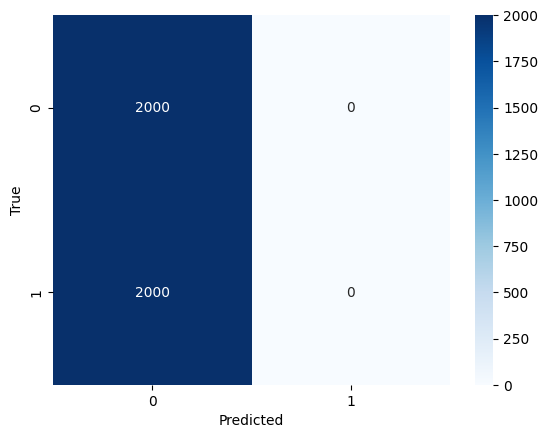

In [65]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2000
           1       0.00      0.00      0.00      2000

    accuracy                           0.50      4000
   macro avg       0.25      0.50      0.33      4000
weighted avg       0.25      0.50      0.33      4000



c:\Users\panda\miniconda3\envs\PLN\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\panda\miniconda3\envs\PLN\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\panda\miniconda3\envs\PLN\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Entrenando otro modelo porque el Bert nomas no

In [17]:
X_train, X_test, y_train, y_test = train_test_split(datos_recortados['FullText'], datos_recortados['Label'], test_size=0.3, random_state=42, stratify=datos_recortados['Label'])

In [18]:
tfidf = TfidfVectorizer(max_features=None)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [19]:
lr_classifier = LogisticRegression(max_iter=1000)

param_grid = {'C': np.arange(0.1, 1.1, 0.1),
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga']}

lr_classifier = GridSearchCV(lr_classifier, param_grid, cv=5, n_jobs=-1)

lr_classifier.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

In [22]:
best_C = lr_classifier.best_params_['C']
best_penalty = lr_classifier.best_params_['penalty']
best_solver = lr_classifier.best_params_['solver']

print(f'Best C: {best_C}')
print(f'Best penalty: {best_penalty}')
print(f'Best solver: {best_solver}')

Best C: 1.0
Best penalty: l2
Best solver: liblinear


In [23]:
y_pred = lr_classifier.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     18533
           1       0.91      0.92      0.92     30000

    accuracy                           0.90     48533
   macro avg       0.89      0.89      0.89     48533
weighted avg       0.89      0.90      0.89     48533



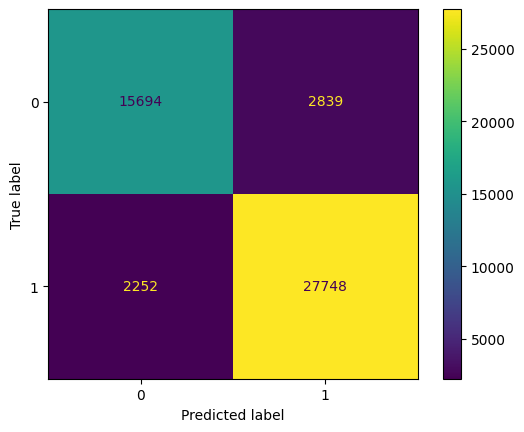

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
    

In [ ]:
joblib.dump(lr_classifier, 'models/logistic_regression.pkl')

['models/logistic_regression.pkl']

## Analisis de temas

### LDA

In [32]:
reviews_negativos = datos_limpio[datos_limpio['Label'] == 0].copy()
reviews_negativos

,FullText,Score,Label
8,tastes like formaldehyde smells disgusting bel...,1,0
16,zuke hip action great giving pound shepherd la...,2,0
19,overpriced full fillers buying realized full j...,1,0
21,worth money sorry far better kona coffee guess...,2,0
22,disappointed extremely disappointed lack quali...,1,0
...,...,...,...
426301,k cups keurig brewer searched k cups product l...,1,0
426306,tasteless tea sorry purchased pack tea new keu...,1,0
426313,ouch bilberry nearly per item bionaturae bilbe...,1,0
426320,matcha matcha wonderful pier mall send matcha ...,1,0


In [38]:
texts = [word_tokenize(review) for review in reviews_negativos['FullText']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [44]:
# Mejor numero de topicos usando LDA
n_topics = [3+k for k in range(0, 5)]
coherences = []

for n in n_topics:
    lda_model = models.LdaModel(corpus, num_topics=n, id2word=dictionary, passes=15)
    cm = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherences.append(cm.get_coherence())

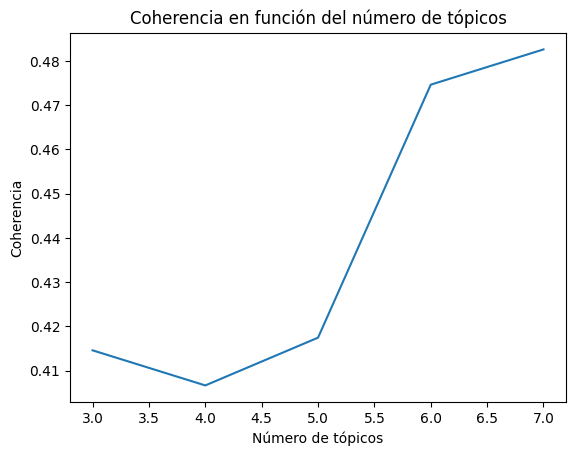

In [45]:
plt.plot(n_topics, coherences)
plt.xlabel("Número de tópicos")
plt.ylabel("Coherencia")
plt.title("Coherencia en función del número de tópicos")
plt.show()

In [ ]:
lda_model = LdaModel(corpus, num_topics=7, id2word=dictionary, passes=20)

In [47]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherencia LDA: {coherence_lda}")

Coherencia LDA: 0.5046124089113996


In [51]:
# Exploracion de los doc
print("LDA")
for i in range(0, 7):
    print(f"Topic {i}")
    topic = lda_model.show_topic(i, 10)
    print(topic)

LDA
Topic 0
[('like', 0.014124232), ('one', 0.012339148), ('would', 0.009718326), ('eat', 0.008602254), ('dog', 0.008590308), ('get', 0.008574153), ('time', 0.0071325623), ('even', 0.006442223), ('good', 0.006131841), ('hard', 0.005606665)]
Topic 1
[('food', 0.03004348), ('eating', 0.0133515885), ('day', 0.012868943), ('would', 0.011639014), ('diet', 0.010449569), ('got', 0.009987508), ('always', 0.009219906), ('three', 0.009116347), ('little', 0.008677417), ('really', 0.008636015)]
Topic 2
[('sugar', 0.016331786), ('product', 0.015727848), ('ingredients', 0.0119059095), ('free', 0.011182068), ('oil', 0.009137039), ('gluten', 0.007451259), ('organic', 0.0073785926), ('natural', 0.0069861757), ('fat', 0.006574391), ('ingredient', 0.0065509067)]
Topic 3
[('taste', 0.03181081), ('like', 0.030551499), ('flavor', 0.018631881), ('tea', 0.01744249), ('good', 0.012475783), ('would', 0.008937239), ('chocolate', 0.008552967), ('really', 0.008322387), ('one', 0.008318683), ('tastes', 0.008209419)

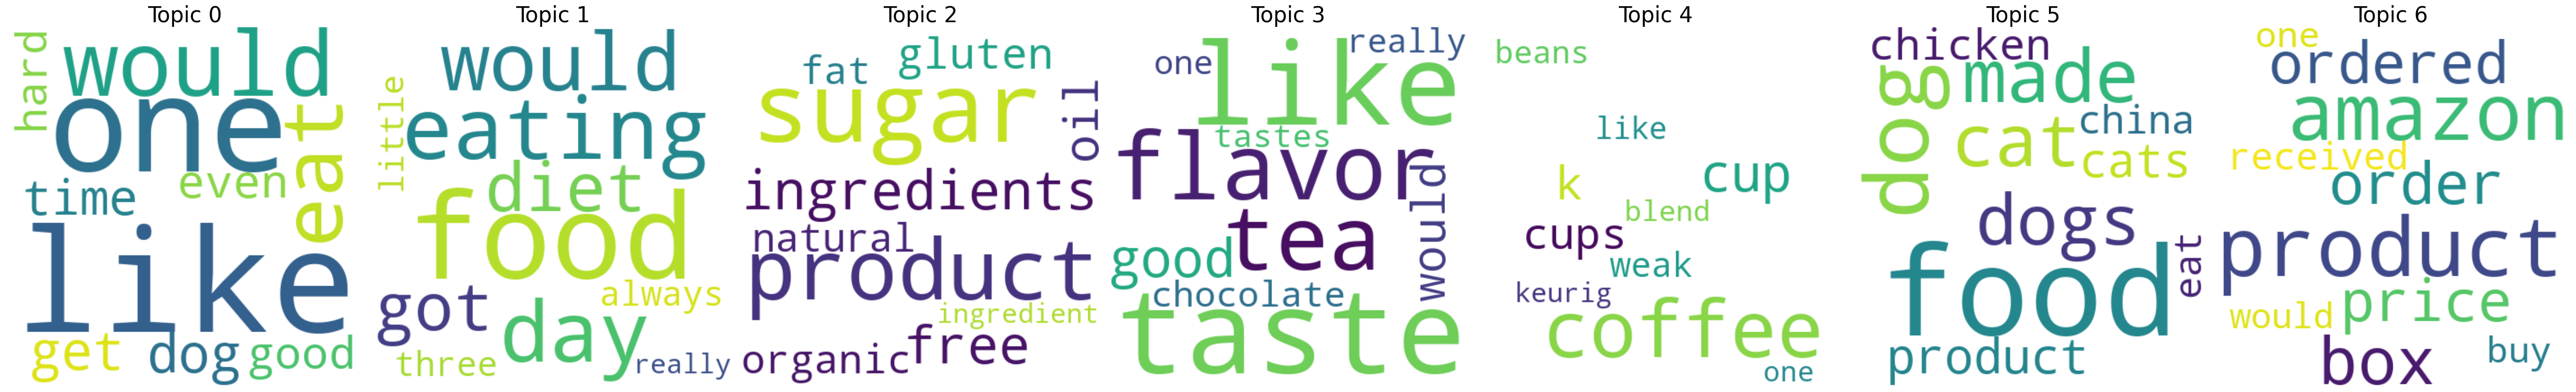

In [58]:
n_topics = 7
fig, axs = plt.subplots(1, n_topics, figsize=(50, 10))

for i in range(n_topics):
    # Obtener los términos del tema LDA
    topic = lda_model.show_topic(i, 10)

    # Generar la nube de palabras
    wordcloud = WordCloud(
        width=400, height=400, background_color='white',  min_font_size=18
    ).generate_from_frequencies(dict(topic))

    # Mostrar en la subfigura correspondiente
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(f"Topic {i}", fontsize=30)
    axs[i].axis("off")

# Ajustar la distribución de los subplots
plt.tight_layout()
plt.show()


### LSA

In [59]:
reviews_negativos = datos_limpio[datos_limpio['Label'] == 0].copy()
reviews_negativos

,FullText,Score,Label
8,tastes like formaldehyde smells disgusting bel...,1,0
16,zuke hip action great giving pound shepherd la...,2,0
19,overpriced full fillers buying realized full j...,1,0
21,worth money sorry far better kona coffee guess...,2,0
22,disappointed extremely disappointed lack quali...,1,0
...,...,...,...
426301,k cups keurig brewer searched k cups product l...,1,0
426306,tasteless tea sorry purchased pack tea new keu...,1,0
426313,ouch bilberry nearly per item bionaturae bilbe...,1,0
426320,matcha matcha wonderful pier mall send matcha ...,1,0


In [63]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)
    Di, Dij = col_i.sum(), col_ij.sum()
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [65]:
vectorizer = TfidfVectorizer(max_features=None)
X = vectorizer.fit_transform(reviews_negativos['FullText'])

In [66]:
# Mejor numero de topicos usando LSA
n_topics = [3+k for k in range(0, 7)]
coherences = []

for n in n_topics:
    svd_model = TruncatedSVD(n_components=n)
    svd_model.fit(X)
    coherences.append(get_average_topic_coherence(X, svd_model.components_, n))

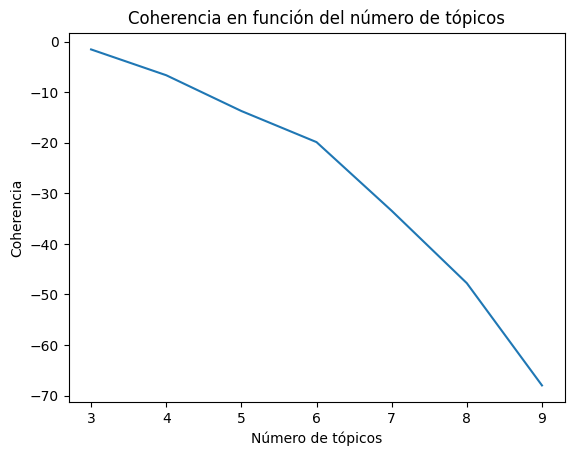

In [67]:
plt.plot(n_topics, coherences)
plt.xlabel("Número de tópicos")
plt.ylabel("Coherencia")
plt.title("Coherencia en función del número de tópicos")
plt.show()

In [105]:
n_topics = 4
svd = TruncatedSVD(n_components= n_topics)
svd.fit(X)

TruncatedSVD(n_components=4)

In [106]:
get_average_topic_coherence(X, svd.components_, n_topics)

-6.40390444454542

In [107]:
print("LSA")
terms = vectorizer.get_feature_names_out()
for i in range(0, n_topics):
    print(f"Topic {i}")
    topic = svd.components_[i]
    topic = sorted(zip(topic, terms), key=lambda x: 1 - x[0])[0:10]
    print(topic)

LSA
Topic 0
[(0.2406780457727042, 'coffee'), (0.2359248766818025, 'like'), (0.2170423766689728, 'taste'), (0.16538894189743197, 'product'), (0.15903579017296873, 'tea'), (0.15242639217479398, 'flavor'), (0.14785235197453242, 'good'), (0.14431084467295782, 'one'), (0.1424498610935373, 'would'), (0.12880476183956593, 'food')]
Topic 1
[(0.7124164862318227, 'coffee'), (0.16792006024888767, 'cup'), (0.12499305793609936, 'weak'), (0.12067650500821371, 'tea'), (0.11356692582994506, 'cups'), (0.08833909137318459, 'flavor'), (0.07929912311011453, 'bitter'), (0.0787048211213013, 'taste'), (0.06358372179606885, 'roast'), (0.06178513915899233, 'strong')]
Topic 2
[(0.7988390104870473, 'tea'), (0.12120536634797734, 'green'), (0.1206419692137255, 'taste'), (0.0844826242402947, 'flavor'), (0.07567692088384222, 'teas'), (0.07393889976823512, 'like'), (0.07016507206820775, 'chai'), (0.06814940763953078, 'stash'), (0.05810342107549963, 'tastes'), (0.0571606285488312, 'bags')]
Topic 3
[(0.4318475170026363

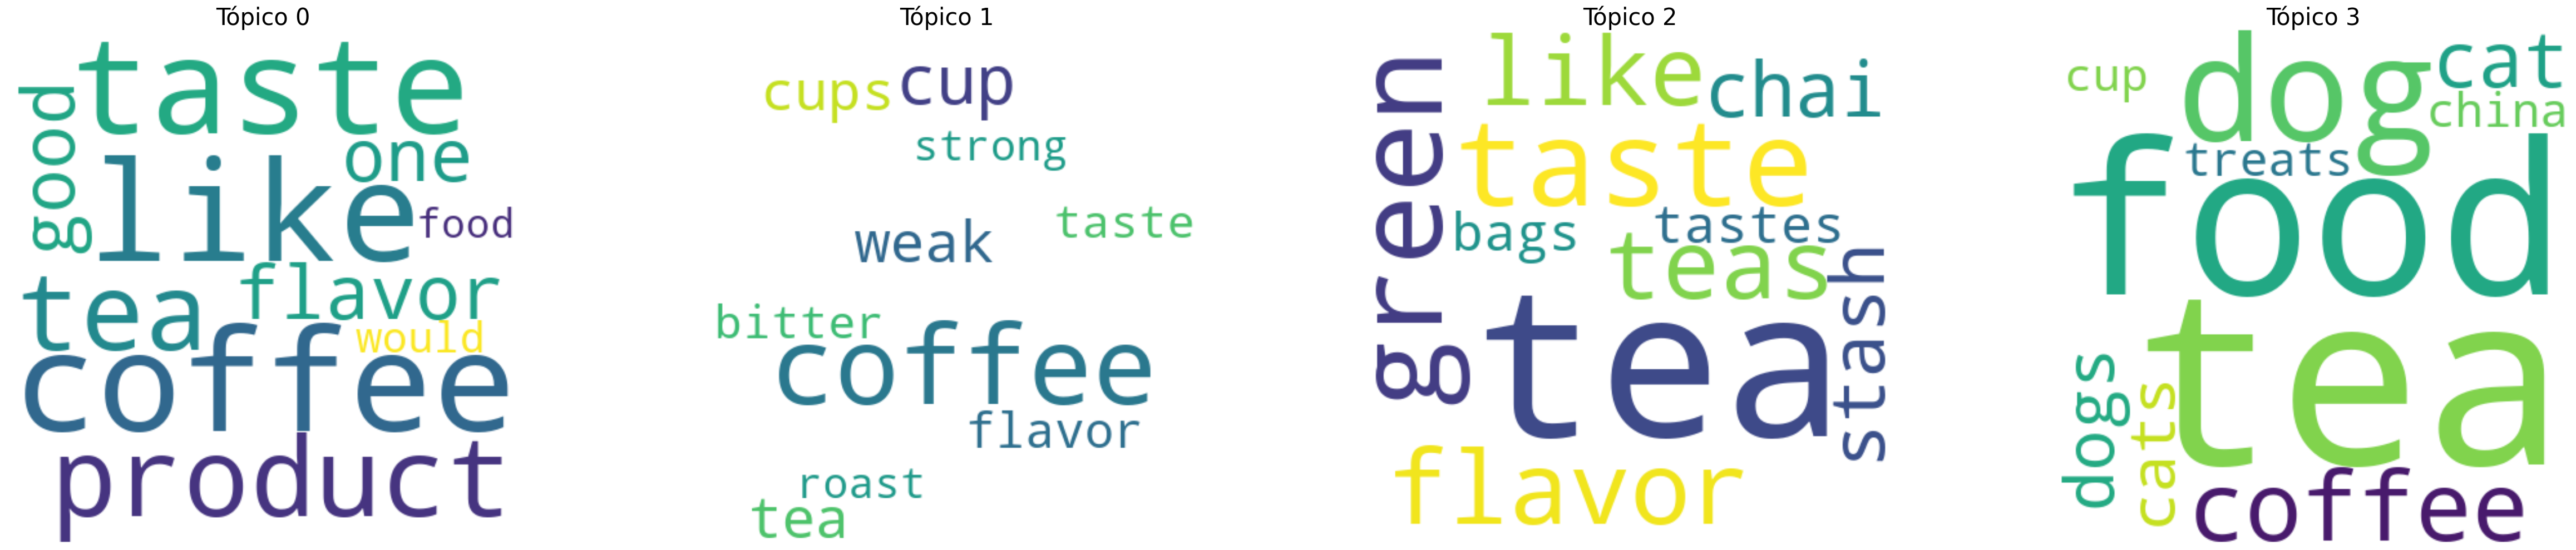

In [108]:
fig, axs = plt.subplots(1, n_topics, figsize=(50, 10))  # Ajustar el tamaño total

for i in range(n_topics):
    # Obtén los componentes del tópico
    topic = svd.components_[i]
    # Asocia términos con sus frecuencias
    topic_terms = sorted(zip(topic, terms), key=lambda x: x[0], reverse=True)[:10]
    topic_dict = {term: abs(freq) for freq, term in topic_terms if isinstance(freq, (int, float))}
    
    # Genera la nube de palabras
    wordcloud = WordCloud(
        width=400, height=400, background_color='white', min_font_size=18
    ).generate_from_frequencies(topic_dict)
    
    # Agrega la nube de palabras a los ejes
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(f"Tópico {i}", fontsize=30)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

## Evaluacion del modelo